In [1]:
from __future__ import print_function, division, absolute_import

As a preamble - note that JuPyTer notebooks are formatted using [markdown](http://daringfireball.net/projects/markdown/), a text-to-html conversion tool. If you are not familiar, there are [cheatsheets](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet) available with all the basic functionality that you will need.

# Building Better Models for Inference:

# How to construct practical models for existing tools

**Version 0.1**

In this notebook, we will walk through fitting a real light curve from a tidal disruption event (TDE), the destruction and accretion of a star by a supermassive black hole, using two different approaches.

As mentioned in the lecture, there are different kinds of models one can apply to a set of data. A code I have written, MOSFiT, is an attempt to provide a framework for building models that can be used within other optimizers/samplers. While MOSFiT can run independently, in the notebook below we will simple be using it as a "black box" function for use in external optimization routines.

Our first approach will be using the `tde` model in MOSFiT. This model uses both interpolation tables and integrations, making an analytical derivative not available. Our second approach will be to construct a simple analytical function to fit the same data. We will then be comparing performance, both in terms of the quality of the resulting solution, but also the speed by which the solution was computed, and in how we relate our solution to what transpired in this event.

* * *

By J Guillochon (Harvard)

*We will be mostly using the mosfit package and scipy routines. Both are available via conda.*

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import mosfit
import time

# Disable "retina" line below if your monitor doesn't support it.
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Problem 1) Fitting data with a blackbox model

In this first cell, we load the data of a particularly well-sampled tidal disruption event from the Pan-STARRS survey, PS1-10jh. This even is notable because it was caught on the rise, peak, and decay, with solid cadence.

In [3]:
# Load the data from the Open Supernova Catalog.
# Note: if loading the data doesn't work, I have a local copy.
my_printer = mosfit.printer.Printer(quiet=True)  # just to avoid spamming from MOSFiT routines.
my_fetcher = mosfit.fetcher.Fetcher()

fetched = my_fetcher.fetch('BBM_data/PS1-10jh.json')[0]

my_model = mosfit.model.Model(model='tde', printer=my_printer)
fetched_data = my_fetcher.load_data(fetched)
my_model.load_data(
    fetched_data, event_name=fetched['name'],
    exclude_bands=['u', 'r', 'i', 'z', 'F225W', 'NUV'],  # ignore all bands but g when computing ln_likelihood.
    smooth_times=100,  # for plotting smooth fits later
    user_fixed_parameters=['covariance'])  # don't use GP objective function.

# Generate 100 random parameter realizations.
x = np.random.rand(100, my_model.get_num_free_parameters())

# Compute time per function call.
start_time = time.time()
ln_likes = [my_model.ln_likelihood(xx) for xx in x]
stop_time = time.time()

print('{}s per function call.'.format((stop_time - start_time)/100.0))


Event file:
  BBM_data/PS1-10jh.json
0.014838411808013915s per function call.


**Problem 1a**

First, let's visualize the data we have downloaded. MOSFiT loads data in a format conforming to the OAC schema specification, which is a JSON dictionary where the top level of the structure is each event's name. The code snippet below will load a JSON dictionary for the event in question, plot the full time series of photometric data (with error bars) within the `photometry` key below.

*Hint: The photometry is a mixture of different data types, and not every entry has the same set of keys. Optical/UV/IR photometry will always have a `band` key. Ignore upper limits (indicated with the `upperlimit` attribute). Use the `.get()` function liberally, and make sure everything is a `float`!*

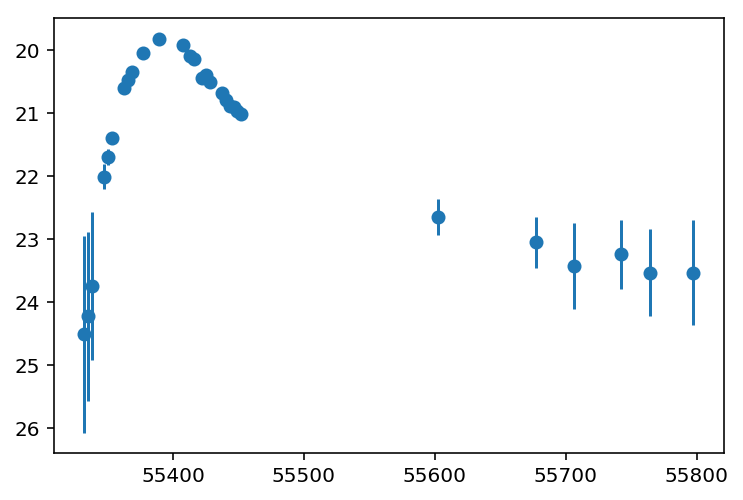

In [4]:
times = []
mags = []
errs = []
for x in fetched_data[fetched['name']]['photometry']:
    if x.get('band') != 'g' or x.get('upperlimit') or not x.get('e_magnitude'):
        continue
    times.append(float(x['time']))
    mags.append(float(x['magnitude']))
    errs.append(float(x['e_magnitude']))

plt.errorbar(times, mags, yerr=errs, fmt='o')
plt.gca().invert_yaxis()
plt.show()

**Problem 1b**

We know what the data looks like, and we've loaded a model that can be used to fit the data which computes a likelihood. Let's minimize the parameters of this model using various `scipy.optimize` routines. Note that since we are trying to **maximize** the likelihood, we have constructed a wrapper function around `ln_likelihood`, `my_func`, to reverse its sign, and to handle bad function evaluations.

Most `optimize` routines in `scipy` require a derivative. Since we don't have this available, `scipy` must construct an approximate one, unless the method doesn't require a gradient to be computed (like `differential_evolution`). For this first sub-problem, optimize `my_func` using `differential_evolution`.

*Hints: Each variable is bounded to the range (0, 1), but problems can arise if an optimizer attempts to compute values outside or right at the boundaries. Therefore, it is recommended to use a bounded optimizer in `scipy`, where the bounds do **not include** 0 or 1.*

In [5]:
import scipy


def my_func(x):
    try:
        fx = -float(my_model.ln_likelihood(x))
    except:
        fx = np.inf
    return fx

eps = 0.00001
# guess = np.full(my_model.get_num_free_parameters(), 0.5)
bounds = np.full((my_model.get_num_free_parameters(), 2), (eps, 1.0 - eps))
results = scipy.optimize.differential_evolution(my_func, bounds=bounds, disp=True, polish=False, maxiter=100)
best_x = results.x

print('All done! Best score: `{}`.'.format(-results.fun))

differential_evolution step 1: f(x)= 22.196
differential_evolution step 2: f(x)= 22.196
differential_evolution step 3: f(x)= 22.196
differential_evolution step 4: f(x)= 21.9109
differential_evolution step 5: f(x)= 21.9109
differential_evolution step 6: f(x)= 21.9109
differential_evolution step 7: f(x)= 21.9109
differential_evolution step 8: f(x)= 21.9109
differential_evolution step 9: f(x)= 21.9109
differential_evolution step 10: f(x)= 21.9109
differential_evolution step 11: f(x)= 21.9109
differential_evolution step 12: f(x)= 21.9109
differential_evolution step 13: f(x)= 21.9109
differential_evolution step 14: f(x)= 21.9109
differential_evolution step 15: f(x)= 21.9109
differential_evolution step 16: f(x)= 21.9109
differential_evolution step 17: f(x)= 21.9109
differential_evolution step 18: f(x)= 21.9109
differential_evolution step 19: f(x)= 21.9109
differential_evolution step 20: f(x)= 21.8795
differential_evolution step 21: f(x)= 21.3839
differential_evolution step 22: f(x)= 21.3839


This might take a while; try to limit the execution time of the above to ~5 minutes by playing with the `maxiter` and similar options of the `scipy` optimizers.

Once the above has finished evaluating, compare the score you got to your neighbors. Is there a significant difference between your scores? Let's plot your result against the data.

Model output is provided in the `output` object below, the format is a dictionary of arrays of the same length. The times of observation are in the `times` array, and magnitudes are in the `model_observations` array.

*Hint: `times` is given relative to the time of the first detection, so add `min(times)` to your time to overplot onto the data.*

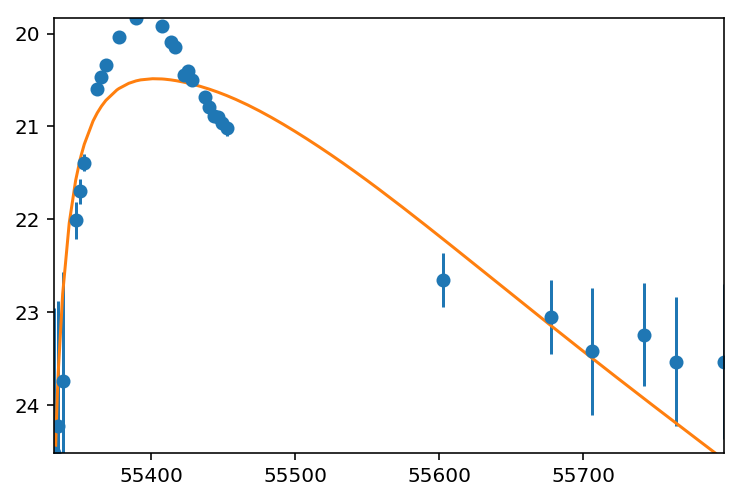

In [7]:
output = my_model.run_stack(best_x, root='output')
mtimes = []
mmags = []

for ti, t in enumerate(output['times']):
    mtimes.append(t + min(times))
    mmags.append(output['model_observations'][ti])

plt.errorbar(times, mags, yerr=errs, fmt='o')
plt.plot(mtimes, mmags)
plt.xlim(min(times) - 10, max(times) + 10)
plt.ylim(min(mags) - 0.5, max(mags) + 0.5)
plt.gca().invert_yaxis()
plt.show()

**Problem 1c**

Try optimizing the same function using **another** minimization routine in scipy that can take a derivative as an input (examples: `L-BFGS-B`, `SLSQP`, `basinhopping`, etc.).

In [8]:
guess = eps + ((1.0 - 2.0 * eps) * np.random.rand(my_model.get_num_free_parameters()))

results = scipy.optimize.basinhopping(my_func, guess, disp=True, niter=100, minimizer_kwargs={
    'method': "SLSQP", 'bounds': bounds})
best_x = results.x

print('All done! Best score: `{}`.'.format(-results.fun))

basinhopping step 0: f -56.3977
basinhopping step 1: f -56.3977 trial_f inf accepted 0  lowest_f -56.3977
basinhopping step 2: f -56.3977 trial_f inf accepted 0  lowest_f -56.3977
basinhopping step 3: f -56.3977 trial_f inf accepted 0  lowest_f -56.3977
basinhopping step 4: f -56.3977 trial_f inf accepted 0  lowest_f -56.3977
basinhopping step 5: f -56.3977 trial_f inf accepted 0  lowest_f -56.3977
basinhopping step 6: f -56.3977 trial_f inf accepted 0  lowest_f -56.3977
basinhopping step 7: f -56.3977 trial_f inf accepted 0  lowest_f -56.3977
basinhopping step 8: f -56.3977 trial_f inf accepted 0  lowest_f -56.3977
basinhopping step 9: f -56.3977 trial_f inf accepted 0  lowest_f -56.3977
basinhopping step 10: f -56.3977 trial_f inf accepted 0  lowest_f -56.3977
basinhopping step 11: f -56.3977 trial_f inf accepted 0  lowest_f -56.3977
basinhopping step 12: f -56.3977 trial_f inf accepted 0  lowest_f -56.3977
basinhopping step 13: f -56.3977 trial_f inf accepted 0  lowest_f -56.3977
ba

Now, plot the results of the above minimization alongside your original `differential_evolution` solution.

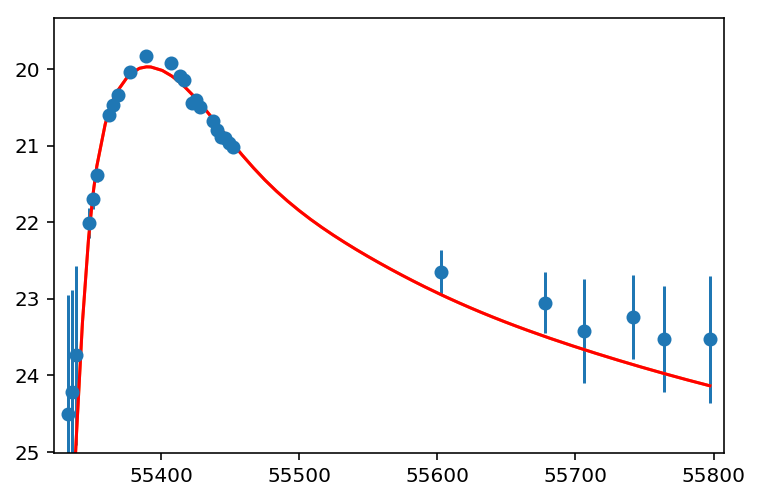

In [11]:
output = my_model.run_stack(best_x, root='output')
mtimes2 = []
mmags2 = []

for ti, t in enumerate(output['times']):
    mtimes2.append(t + min(times))
    mmags2.append(output['model_observations'][ti])

plt.errorbar(times, mags, yerr=errs, fmt='o')
plt.plot(mtimes, mmags)
plt.plot(mtimes2, mmags2, c='r')
plt.xlim(min(times) - 10, max(times) + 10)
plt.ylim(min(mags) - 0.5, max(mags) + 0.5)
plt.gca().invert_yaxis()
plt.show()

After this process, **some** of you **might** have gotten a good solution with a runtime of a few minutes. In practice, guaranteed convergence to the best solution can take a very long time. Whats more, we only attempted to find the **best** solution available, usually we are interested in posterior distributions that (usually) include the best solution. These take even longer to compute (tens of thousands of function evaluations for a problem of this size).

## Problem 2

Now, we'll construct our own simpler model that is **analytically differentiable**. We'll partly motivate the shape of this function based upon our knowledge of how tidal disruption events are expected to behave theoretically, but there will be limitations.

First, let's define a function that loosely mimics a tidal disruption event's temporal evolution. Tidal disruption events rise exponentially, then decay as a power-law. Canonically, the decay rate is -5/3, and the rise is very unconstrained, being mediated by complicated dynamics and accretion physics that have yet to be determined. So, we use the following agnostic form,

$$L(t) = L_0 \left(1-e^{-\frac{t}{t_0}}\right)^{\alpha } \left(\frac{t}{t_0}\right)^{-\beta }.$$

Tidal disruption observations are usually reported in magnitudes, thus the expression we'll actually compare against observations is

$$m(t) = m_0 - 2.5 \log_{10}\left[\left(1-e^{-\frac{t}{t_0}}\right)^{\alpha } \left(\frac{t}{t_0}\right)^{-\beta }\right].$$

To calculate the likelihood, we want to subtract the above from the observations. We'll make the gross assumption that the color of a tidal disruption is constant in time (which turns out to not be a terrible assumption) and thus $L_{\rm g}(t) \propto L(t)$.

Our likelihood function will be defined as the product of the squares of differences between our model and observation,

$$p = \prod_i \frac{1}{\sqrt{2\pi (\sigma_i^2 + \sigma^2)}} \left(\frac{m_{{\rm g}, i} - \bar{m}_{{\rm g}, i}}{\sigma_i^2 + \sigma^2}\right),$$

and thus our log likelihood is the sum of these squared differences, plus a separate sum for the variances,

$$\log p = -\frac{1}{2} \left[\sum_i \left(m_{{\rm g}, i} - \bar{m}_{{\rm g}, i}\right) + \log 2\pi \left(\sigma_i^2 + \sigma^2\right)\right].$$

** Problem 2a **

Compute the derivatives for $\log p$ (above expression) with respect to $m_0$, $\alpha$, $\beta$, $t_0$, and $\sigma$ (Mathematica might be helpful here).

**Problem 2a Solution**

$$
\begin{align}
\frac{\partial\log p}{\partial m_0} &= m_0-\frac{5 \log \left[\left(1-e^{-\frac{t_i}{t_0}}\right)^{\alpha } \left(\frac{t_i}{t_0}\right)^{-\beta }\right]}{2 \log (10)}\\
\frac{\partial\log p}{\partial \alpha} &= 2 \left\{-\frac{5 \log \left[\left(1-e^{-\frac{t}{t_0}}\right)^{\alpha } \left(\frac{t}{t_0}\right)^{-\beta }\right]}{\log (100)}-\bar{m}+m_0\right\}^{-1}\\
\frac{\partial\log p}{\partial \beta} &= -\frac{10 \log \left(1-e^{-\frac{t}{t_0}}\right)}{2 \log (10) (m_0-\bar{m})-5 \log \left[\left(1-e^{-\frac{t}{t_0}}\right)^{\alpha } \left(\frac{t}{t_0}\right)^{-\beta }\right]}\\
\frac{\partial\log p}{\partial t_0} &= \frac{10 \log \left(\frac{t}{t_0}\right)}{2 \log (10) (m_0-\bar{m})-5 \log \left[\left(1-e^{-\frac{t}{t_0}}\right)^{\alpha } \left(\frac{t}{t_0}\right)^{-\beta }\right]}\\
\frac{\partial\log p}{\partial \sigma} &= \frac{10 \left[\alpha  t-\beta  t_0 \left(e^{t/t_0}-1\right)\right]}{t_0^2 \left(e^{t/t_0}-1\right) \left\{2 \log (10) (m_0-\bar{m})-5 \log \left[\left(1-e^{-\frac{t}{t_0}}\right)^{\alpha } \left(\frac{t}{t_0}\right)^{-\beta }\right]\right\}}
\end{align}
$$

**Problem 2b**

Write each of these derivatives as python functions. These functions should accept a single vector argument `x` with length equal to the number of free parameters, plus a vector $t$ (the times of the observation) and a vector $m$ (the magnitudes of each observation).

In [45]:
def lf(alpha, beta, t0, t):
    return np.log(((1.0 - np.exp(-t / t0)) ** alpha) * (t / t0) ** (-beta))

def dlogp_dm0(x, tt, mm):
    m0, alpha, beta, t0, sigma = tuple(x)
    t = np.array(tt)
    
    derivs = m0 - 5.0 / (2.0 * np.log(10.0)) * lf(alpha, beta, t0, t)
    
    return derivs

def dlogp_dalpha(x, tt, mm):
    m0, alpha, beta, t0, sigma = tuple(x)
    t = np.array(tt)
    m = np.array(mm)
    
    derivs = 2.0 / (-5.0 / (2.0 * np.log(10.0)) * lf(alpha, beta, t0, t) / np.log(100.0) - m + m0)
    
    return derivs

def dlogp_dbeta(x, tt, mm):
    m0, alpha, beta, t0, sigma = tuple(x)
    t = np.array(tt)
    m = np.array(mm)
    
    derivs = -10.0 * np.log(1.0 - np.exp(-t / t0))/(
        2.0 * np.log(10.0) * (m0 - m) - 5.0 * lf(alpha, beta, t0, t))
    
    return derivs

def dlogp_dt0(x, tt, mm):
    m0, alpha, beta, t0, sigma = tuple(x)
    t = np.array(tt)
    m = np.array(mm)
    
    derivs = 10.0 * np.log(t / t0)/(2.0 * np.log(10.0) * (m0 - m) - 5.0 * lf(alpha, beta, t0, t))
    
    return derivs

def dlogp_dsigma(x, tt, mm):
    m0, alpha, beta, t0, sigma = tuple(x)
    t = np.array(tt)
    m = np.array(mm)
    
    derivs = (10.0 * (alpha * t - beta * t0 * np.exp(-t / t0) - 1.0))/(t0 ** 2.0 * (np.exp(-t / t0) - 1.0) * (
        2.0 * np.log(10.0) * (m0 - m) - 5.0 * lf(alpha, beta, t0, t)))
    
    return derivs

test_times = [1.0, 10.0]
test_mags = [23.0, 19.0]
test_x = [20, 2.0, 5.0/3.0, 10.0, 1.0]
print(dlogp_dm0(test_x, test_times, test_mags))
print(dlogp_dalpha(test_x, test_times, test_mags))
print(dlogp_dbeta(test_x, test_times, test_mags))
print(dlogp_dt0(test_x, test_times, test_mags))
print(dlogp_dsigma(test_x, test_times, test_mags))

[ 20.94100225  20.99600042]
[-0.71539356  1.64435991]
[-2.48065784  0.4989981 ]
[ 2.42836594  0.        ]
[-1.5604653  -0.22147649]


Alright, now we have an analytical function with analytical derivatives that should be accurate to near-machine precision. First, let's optimize our function using `differential_evolution`, as we did above, without using the derivatives we have constructed.

## Challenge Problem

Complete the following problem, which can be arbitrarily difficult.

In [ ]:
# no code snippets provided here